### Conway's game of life
- Cellular automata simulation invented by the British mathematician John Conway in 1970
- Zero-player game that consists of a 2D binary lattice of cells (Live or Dead)
    - Any live cell < 2 live neighbors dies
    - Any live cell 2-3 live neighbors lives
    - Any live cell > 3 live neighbors dies
    - Any dead cell 3 live neighbors back to life

- Each cell in the lattice can be managed by a single CUDA thread, apply knowledge of blocks & grids
- Implement LIFE as a CUDA kernel & animate via matplotlib.animation module

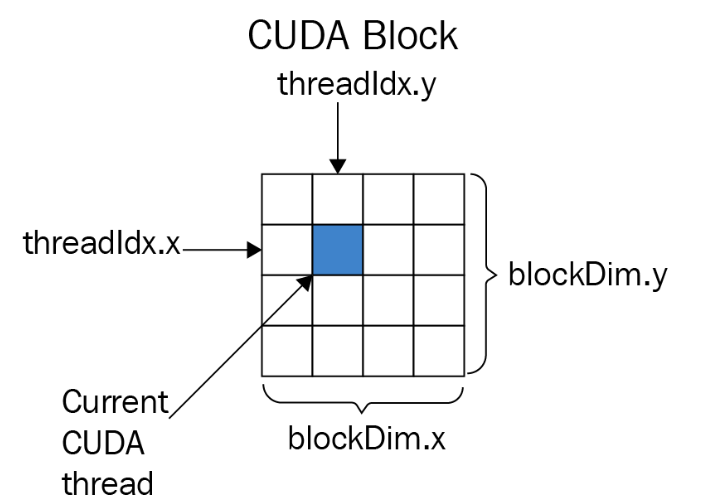

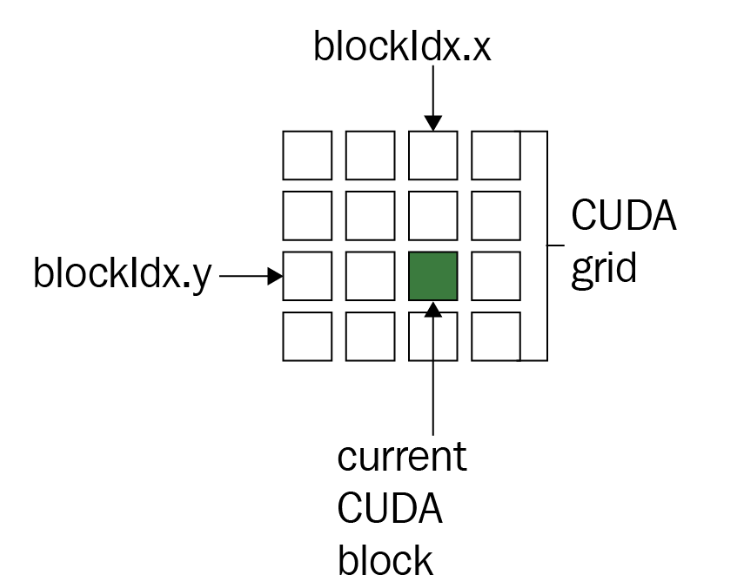

- PyCUDA passes 2D arrays into CUDA C as 1D pointers; 2D arrays are passed in row-wise from Python into one dimensional C pointers. 
- As the cell lattice is stored row-wise, then need to multiply the y-value by the width to offset to the point corresponding to the appropriate row
- device function: C function written in serial, which is called by an individual CUDA thread in kernel, __device__
    - function will be called in parallel by multiple threads from kernel
    - "A CUDA device function is a serial C function that is called by an individual CUDA thread from within a kernel. While these functions are serial in themselves, they can be run in parallel by multiple GPU threads. Device functions cannot by themselves by launched by a host computer onto a GPU, only kernels."

C:\Users\foonwong\AppData\Local\Temp\ipykernel_26304\1891728005.py:16: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  ker = SourceModule("""
C:\Users\foonwong\AppData\Local\Temp\ipykernel_26304\1891728005.py:99: UserWarning: You passed in an explicit save_count=1000 which is being ignored in favor of frames=1000.
  ani = animation.FuncAnimation(fig, update_gpu, fargs=(img, newLattice_gpu, lattice_gpu, N, ) , interval=0, frames=1000, save_count=1000)


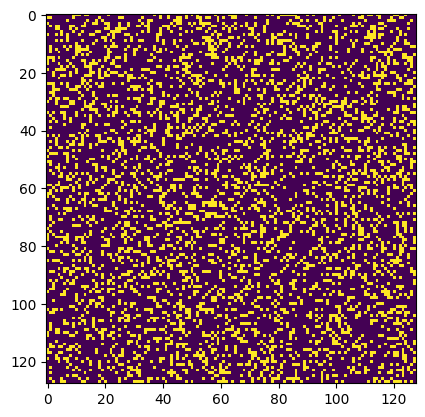

In [1]:
# Conway's game of life in Python / CUDA C
# written by Brian Tuomanen for "Hands on GPU Programming with Python and CUDA"

import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

# C language's #define directive to set up some constants & macros
# #define will literally replace any text of _X or _Y with the defined values (in the parentheses here) at compilation time, which creates macros
# Preference: precede C macros with an underscore
# In C and C++, #define is used for creating macros, which doesn't create any function or set up a proper constant variables
ker = SourceModule("""
#define _X  ( threadIdx.x + blockIdx.x * blockDim.x )
#define _Y  ( threadIdx.y + blockIdx.y * blockDim.y )

#define _WIDTH  ( blockDim.x * gridDim.x )
#define _HEIGHT ( blockDim.y * gridDim.y  )

#define _XM(x)  ( (x + _WIDTH) % _WIDTH )
#define _YM(y)  ( (y + _HEIGHT) % _HEIGHT )

#define _INDEX(x,y)  ( _XM(x)  + _YM(y) * _WIDTH )

// return the number of living neighbors for a given cell                
__device__ int nbrs(int x, int y, int * in)
{
     return ( in[ _INDEX(x -1, y+1) ] + in[ _INDEX(x-1, y) ] + in[ _INDEX(x-1, y-1) ] \
                   + in[ _INDEX(x, y+1)] + in[_INDEX(x, y - 1)] \
                   + in[ _INDEX(x+1, y+1) ] + in[ _INDEX(x+1, y) ] + in[ _INDEX(x+1, y-1) ] );
}

__global__ void conway_ker(int * lattice_out, int * lattice  )
{
   // x, y are the appropriate values for the cell covered by this thread
   int x = _X, y = _Y;
   
   // count the number of neighbors around the current cell
   int n = nbrs(x, y, lattice);
                   
    
    // if the current cell is alive, then determine if it lives or dies for the next generation.
    if ( lattice[_INDEX(x,y)] == 1)
       switch(n)
       {
          // if the cell is alive: it remains alive only if it has 2 or 3 neighbors.
          case 2:
          case 3: lattice_out[_INDEX(x,y)] = 1;
                  break;
          default: lattice_out[_INDEX(x,y)] = 0;                   
       }
    else if( lattice[_INDEX(x,y)] == 0 )
         switch(n)
         {
            // a dead cell comes to life only if it has 3 neighbors that are alive.
            case 3: lattice_out[_INDEX(x,y)] = 1;
                    break;
            default: lattice_out[_INDEX(x,y)] = 0;         
         }
         
}
""")


conway_ker = ker.get_function("conway_ker")
     
# frameNum: a value that is required by Matplotlib's animation module for update functions  (ignore)
# img: representative image of the cell lattice that is required by the module that will be iteratively displayed
def update_gpu(frameNum, img, newLattice_gpu, lattice_gpu, N):
    # The number of threads in a CUDA block is limited to a maximum of 1,024
    # block sizes as 32 x 32 with (32, 32, 1)
    conway_ker(  newLattice_gpu, lattice_gpu, grid=(N/32,N/32,1), block=(32,32,1)   )
    
    # set up the image data for animation after grabbing the latest generated lattice from the GPU's memory with the get()
    img.set_data(newLattice_gpu.get() )
    
    
    lattice_gpu[:] = newLattice_gpu[:]
    
    return img
    

if __name__ == '__main__':
    # set lattice size
    N = 128
    
    lattice = np.int32( np.random.choice([1,0], N*N, p=[0.25, 0.75]).reshape(N, N) )
    # current generation of the cell array that will correspond to the lattice parameter in the kernel
    lattice_gpu = gpuarray.to_gpu(lattice)
    
    # next generation of the lattice (NXN lattice)
    newLattice_gpu = gpuarray.empty_like(lattice_gpu)        

    fig, ax = plt.subplots()
    img = ax.imshow(lattice_gpu.get(), interpolation='nearest')
    ani = animation.FuncAnimation(fig, update_gpu, fargs=(img, newLattice_gpu, lattice_gpu, N, ) , interval=0, frames=1000, save_count=1000)    
     
    plt.show()
